In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from os import walk
import datetime
from tqdm import tqdm
from numba import jit  
from sklearn.preprocessing import MinMaxScaler
import datetime as dtm
import lightgbm as lgb
from sklearn import preprocessing, metrics
import seaborn as sns
import time
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('train.csv',',')
test=pd.read_csv('test.csv',',')

In [3]:
train.head(3)

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0


In [4]:
test.head(3)

,city,floor,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type
0,Курск,1.0,COL_289284,7,55,85,117,0,0,0,...,1966.471591,1966.740260,Курская область,51.709255,36.147908,156.148996,S6983,2020-09-06,100,1
1,Сургут,1.0,COL_289305,8,70,112,140,0,0,0,...,1988.259259,1989.068182,Ханты-Мансийский АО,61.233240,73.462509,190.737943,S29120,2020-09-06,110,1
2,Тюмень,-1.0,COL_289318,3,28,67,122,0,0,0,...,1985.880282,1991.458333,Тюменская область,57.143110,65.554573,457.118051,S23731,2020-09-06,10,1


# CREATE FEAS AND PREPARE DATASET

In [5]:
predictors=['floor_id','city_id','lat','lng','osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist', 'osm_city_nearest_population',
       'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001',
       'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
       'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
       'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
       'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
       'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
       'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005',
       'osm_healthcare_points_in_0.0075', 'osm_healthcare_points_in_0.01',
       'osm_historic_points_in_0.005', 'osm_historic_points_in_0.0075',
       'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.005',
       'osm_hotels_points_in_0.0075', 'osm_hotels_points_in_0.01',
       'osm_leisure_points_in_0.005', 'osm_leisure_points_in_0.0075',
       'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.001',
       'osm_offices_points_in_0.005', 'osm_offices_points_in_0.0075',
       'osm_offices_points_in_0.01', 'osm_shops_points_in_0.001',
       'osm_shops_points_in_0.005', 'osm_shops_points_in_0.0075',
       'osm_shops_points_in_0.01', 'osm_subway_closest_dist',
       'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
       'osm_train_stop_points_in_0.0075', 'osm_train_stop_points_in_0.01',
       'osm_transport_stop_closest_dist',
       'osm_transport_stop_points_in_0.005',
       'osm_transport_stop_points_in_0.0075',
       'osm_transport_stop_points_in_0.01','month','day','price_type','total_square']
target='per_square_meter_price'

In [6]:
#CITY DICT
cts=pd.DataFrame(train['city'].drop_duplicates().reset_index(drop=True))
cts['city_id']=cts.index
train=pd.merge(cts,train,how='left',on='city')
test=pd.merge(cts,test,how='left',on='city')
#REGION DICT
rgn=pd.DataFrame(train['region'].drop_duplicates().reset_index(drop=True))
rgn['region_id']=rgn.index
train=pd.merge(rgn,train,how='left',on='region')
test=pd.merge(rgn,test,how='left',on='region')
#FLOORS DICT
train['floor']=train['floor'].fillna(-1)
test['floor']=test['floor'].fillna(-1)
flr=pd.DataFrame(train['floor'].drop_duplicates().reset_index(drop=True))
flr['floor_id']=flr.index
train=pd.merge(flr,train,how='left',on='floor')
test=pd.merge(flr,test,how='left',on='floor')
#TIME FEAS
train['Date'],test['Date']=train['date'].astype('datetime64[ns]'),test['date'].astype('datetime64[ns]')
train['Year']=train['Date'].dt.year
train['month']=train['Date'].dt.month
train['day']=train['Date'].dt.day
test['Year']=test['Date'].dt.year
test['month']=test['Date'].dt.month
test['day']=test['Date'].dt.day
test.head(3)

,floor,floor_id,region,region_id,city,city_id,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,...,lng,total_square,street,date,realty_type,price_type,Date,Year,month,day
0,-1,0,Пермский край,0.0,Пермь,0.0,COL_301220,0.0,47.0,125.0,...,56.243041,6683.779613,S12321,2020-09-13,10.0,1.0,2020-09-13,2020.0,9.0,13.0
1,-1,0,Пермский край,0.0,Пермь,0.0,COL_307043,2.0,54.0,213.0,...,56.257829,98.848219,S20753,2020-09-13,100.0,1.0,2020-09-13,2020.0,9.0,13.0
2,-1,0,Пермский край,0.0,Пермь,0.0,COL_331559,0.0,47.0,134.0,...,56.241633,7229.268979,S12321,2020-10-04,100.0,1.0,2020-10-04,2020.0,10.0,4.0


In [7]:
def filter_data(df):
    result=[]
    for ct in tqdm(df['city'].drop_duplicates()):
        df_t=df[df['city']==ct]
        df_t=df_t[df_t[target]<df_t[target].mean()+(3*df_t[target].std())]
        df_t=df_t[df_t[target]>df_t[target].mean()-(3*df_t[target].std())]
        result.append(df_t)
    result=pd.concat(result).sort_values(by='Date').reset_index(drop=True)
    return(result)
train_filter=filter_data(train)
train_filter

100%|██████████| 4948/4948 [01:08<00:00, 72.03it/s]


,floor,floor_id,region,region_id,city,city_id,id,lat,lng,osm_amenity_points_in_0.001,...,reform_mean_year_building_500,total_square,street,date,realty_type,price_type,Date,Year,month,day
0,-1,0,Пермский край,0,Пермь,0,COL_0,57.998207,56.292797,4,...,1960.959184,32.0,S27289,2020-01-05,10,0,2020-01-05,2020,1,5
1,-1,0,Калининградская область,13,Калининград,91,COL_3665,54.689518,20.461523,0,...,1994.000000,9709.0,S32802,2020-01-05,10,0,2020-01-05,2020,1,5
2,-1,0,Калининградская область,13,Калининград,91,COL_3632,54.734497,20.555664,0,...,1982.425000,137.0,S28593,2020-01-05,10,0,2020-01-05,2020,1,5
3,-1,0,Калининградская область,13,Калининград,91,COL_3609,54.714832,20.427393,0,...,1966.020408,74.4,S25576,2020-01-05,10,0,2020-01-05,2020,1,5
4,-1,0,Калининградская область,13,Калининград,91,COL_3492,54.709180,20.503677,1,...,1974.285714,556.0,S16738,2020-01-05,10,0,2020-01-05,2020,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274367,-1,0,Кировская область,5,Киров,87,COL_275029,58.626026,49.644386,3,...,1958.529412,70.0,S18524,2020-08-23,10,0,2020-08-23,2020,8,23
274368,-1,0,Кировская область,5,Киров,87,COL_275210,58.592854,49.612580,0,...,1984.956522,334.2,S20312,2020-08-23,100,0,2020-08-23,2020,8,23
274369,-1,0,Кировская область,5,Киров,87,COL_275283,58.587580,49.658722,1,...,1974.631579,148.5,S18524,2020-08-23,110,0,2020-08-23,2020,8,23
274370,-1,0,Кировская область,5,Киров,87,COL_276460,58.597480,49.643814,0,...,1973.696970,165.0,S14817,2020-08-23,100,0,2020-08-23,2020,8,23


LOG DATA


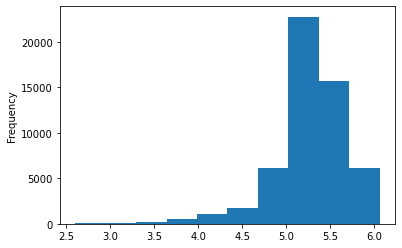

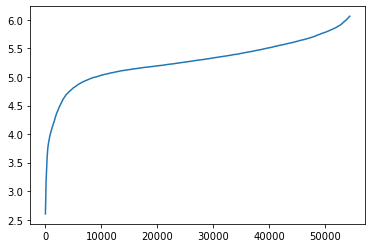

In [8]:


print('LOG DATA')
train=train_filter.copy()
train[target]=np.log10(train[target]+1)
distr=train[train['city']=='Москва']
distr[target].plot.hist()
plt.show()

distr=distr.sort_values(by=target)
plt.plot(distr[target].values)
plt.show()


## scale data

In [9]:
def scale_data(df,target,cts):
    result=[]
    scale_dict={}
    for ct in tqdm(df['city'].drop_duplicates()):
        df_t=df[df['city']==ct].copy()
        scaler = MinMaxScaler()
        df_t[target]=scaler.fit_transform(df_t[target].values.reshape(-1,1))
        scale_dict[ct]=scaler
        result.append(df_t)
    result=pd.concat(result).sort_values(by='Date').reset_index(drop=True)
    return(df,scale_dict)

scale_flag=0
if(scale_flag==1):
    train_scaled,scale_dict=scale_data(train,target,cts)
else:
    train_scaled=train.copy()

## PCA

In [10]:
PCA_flag=0
if(PCA_flag==1):
    pca_breast = PCA(n_components=len(predictors))
    train_scaled_pca = pd.DataFrame(pca_breast.fit_transform(train_scaled[predictors].fillna(-1)))
    train_scaled_pca[target]=train_scaled[target]
    predictors=list(range(len(predictors)))
    train_scaled_pca.head(3)

## Split train

In [11]:
part1=0.75
part2=0.2
part2=part1+part2
if(PCA_flag==1):
    trn,val,tst=train_scaled_pca[:int(len(train)*part1)],train_scaled_pca[int(len(train)*part1):int(len(train)*part2)],train_scaled_pca[int(len(train)*part2):]
else:
    trn,val,tst=train_scaled[:int(len(train)*part1)],train_scaled[int(len(train)*part1):int(len(train)*part2)],train_scaled[int(len(train)*part2):]
train_X,train_y=trn[predictors],trn[target]
val_X,val_y=val[predictors],val[target]
test_X,test_y=tst[predictors],tst[target]

# MODEL

In [ ]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

def metric_calc(df,target):
    df['dev']=(df['Predict']-df[target])/df[target]
    accur=[]
    w=1.1
    for index,row in df.iterrows():
        if(row['dev']<-0.6):
            accur.append(9*w)
        elif((row['dev']>=-0.6)&(row['dev']<-0.15)):
            accur.append(w*(1+(row['dev']/0.15))**2)
        elif((row['dev']>=-0.15)&(row['dev']<0.15)):
            accur.append(0)
        elif((row['dev']>=0.15)&(row['dev']<0.6)):
            accur.append(((row['dev']/0.15)-1)**2)
        elif(row['dev']>=0.6):
            accur.append(9)
    df['accur']=accur
    accur=df['accur'].sum()/len(df['accur'])
    print('ACCURACY WEIGHT: '+str(accur))
    return()

def FitGBM(X_train,Y_train, X_val, Y_val,test,boost='goss',obj='mae',depth=-1):
    
    step=0.15    
    if(obj=='tweedie'):
        metric='tweedie'
    elif(obj=='mae'):
        metric='mae'
    elif(obj=='mae'):
        metric='mse'
    elif(obj=='mape'):
        metric='mape'
    elif(obj=='huber'):
        metric='huber'
    elif(obj=='poisson'):
        metric='mse'
    elif(obj=='quantile'):
        metric='quantile'
    elif(obj=='fair'):
        metric='fair'
        
    params = {
        'boosting_type': boost,
        'metric': metric,
        'objective': obj,
        'n_jobs': -1,
        'seed':25,
        #'learning_rate':step,
        'n_estimators':50000,
        'max_depth':depth,
        #'num_leaves':2**depth,
        #'extra_trees':True,
        #'verbose':-1
        }
    
    train_set = lgb.Dataset(X_train, Y_train)
    val_set = lgb.Dataset(X_val, Y_val)
    gbm = lgb.train(params,train_set,  learning_rates=lambda iter: step * (0.9995 ** iter),
     early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)
    print('Validate model LOG')
    test['Predict']=gbm.predict(test[predictors])
    Accuracy= np.round(1 - \
                            (np.abs(test[target]-test['Predict']
                                    ).sum()/test[target].sum()),2)*100
    print('Model Accuracy: '+str(Accuracy))
    print('Validate model UNLOG')
    test['Predict']=10**gbm.predict(test[predictors])-1
    test['target_unlog']=10**test[target]-1
    Accuracy= np.round(1 - \
                            (np.abs(test['target_unlog']-test['Predict']
                                    ).sum()/test['target_unlog'].sum()),2)*100
    print('Model Accuracy: '+str(Accuracy))
    #plotImp(model,X_val)
    metric_calc(test,'target_unlog')
    return(gbm)

model=FitGBM(train_X,train_y,val_X,val_y,tst)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8151
[LightGBM] [Info] Number of data points in the train set: 205779, number of used features: 64
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 4.776009
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[Light

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[300]	training's l1: 0.19537	valid_1's l1: 0.208912
[LightGBM] [Info] Us

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[1400]	training's l1: 0.173522	valid_1's l1: 0.1972
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Us

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[1700]	training's l1: 0.171044	valid_1's l1: 0.195974
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] 

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[2000]	trainin

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[3100]	training's l1: 0.167256	valid_1's l1: 0.194206
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] 

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[3400]	training's l1: 0.166732	valid_1's l1: 0.193969
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] 

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[4800]	training's l1: 0.16625	valid_1's l1: 0.193772
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] U

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[5100]	training's l1: 0.166173	valid_1's l1: 0.193738
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] 

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [In

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS


# PREDICT

In [ ]:
test[target+'_n']=10**model.predict(test[predictors])-1
submit=pd.read_csv('Submit.csv',',')
submit=pd.merge(submit,test[['id',target+'_n']],how='left',on='id')
submit[target]=submit[target+'_n'].fillna(0)
submit=submit[['id',target]]
submit

In [ ]:
submit.to_csv('result'+str(7)+'.csv',',',index=False)

In [ ]:
def plotImp(model, X , num = 80, fig_size = (40, 40)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(model,val_X)